In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import csv
import os
import matplotlib
import keras
from tensorflow.python.client import device_lib
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf



2023-11-18 20:50:24.821282: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 20:50:25.143350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 20:50:25.143397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 20:50:25.202769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 20:50:25.339243: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-18 20:50:25.341530: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:

print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7024137792979651063
xla_global_id: -1
]


2023-11-18 20:50:29.157747: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 20:50:29.304999: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")


params

In [5]:
initializer1 = tf.keras.initializers.HeNormal(seed=None)
bn_mtc = tf.keras.metrics.BinaryAccuracy(
    name='binary_accuracy', dtype=None, threshold=0.5
)
bn_cross_entrp = tf.keras.metrics.BinaryCrossentropy(
    name='binary_crossentropy',
    dtype=None,
    from_logits=False,
    label_smoothing=0
)
save_best_callback = ModelCheckpoint(
    'best_arin.h5',  
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=0
)

2023-11-18 20:50:35.524906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 20:50:35.524965: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Models

In [ ]:
def arin_2():
    input_non_rs = Input(shape=(4,)) 
    x = BatchNormalization()(input_non_rs)
    x = layers.Dense(256, activation = 'elu')(x)

    input_non_rs_hm = Input(shape=(4,))
    y = BatchNormalization()(input_non_rs_hm)
    y = layers.Dense(256, activation = 'elu')(y)


    non_rs = layers.Concatenate()([y, x])
    z = layers.Dense(512, activation = 'elu', kernel_initializer = initializer1)(non_rs)
    output = layers.Dense(1, activation = 'sigmoid')(z)

    arin2 = Model(inputs = [input_non_rs, input_non_rs_hm], outputs = output, name = "ARIN2")
    arin2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    arin2.summary()
    
    return arin2



In [60]:
df_train = train.drop(["Cabin", "Name"], axis= 1)

df_train["RoomService"].fillna(0, inplace=True)
df_train["FoodCourt"].fillna(0, inplace=True)
df_train["ShoppingMall"].fillna(0, inplace=True)
df_train["Spa"].fillna(0, inplace=True)
df_train["VRDeck"].fillna(0, inplace=True)

df_train.loc[df_train["Destination"]=="TRAPPIST-1e", "Destination"]=0
df_train.loc[df_train["Destination"]=="55 Cancri e", "Destination"]=1
df_train.loc[(df_train["Destination"] != "55 Cancri e") & (df_train["Destination"] != "TRAPPIST-1e"),"Destination"]=2
df_train.loc[df_train["HomePlanet"]=="Earth", "HomePlanet"]=0
df_train.loc[df_train["HomePlanet"]=="Europa", "HomePlanet"]=1
df_train.loc[df_train["HomePlanet"]=="Mars", "HomePlanet"]=2

df_test = test.drop(["Cabin", "Name"], axis= 1)

df_test["RoomService"].fillna(0, inplace=True)
df_test["FoodCourt"].fillna(0, inplace=True)
df_test["ShoppingMall"].fillna(0, inplace=True)
df_test["Spa"].fillna(0, inplace=True)
df_test["VRDeck"].fillna(0, inplace=True)

df_test.loc[df_test["Destination"]=="TRAPPIST-1e", "Destination"]=0
df_test.loc[df_test["Destination"]=="55 Cancri e", "Destination"]=1
df_test.loc[(df_test["Destination"] != "55 Cancri e") & (df_test["Destination"] != "TRAPPIST-1e"),"Destination"]=2
df_test.loc[df_test["HomePlanet"]=="Earth", "HomePlanet"]=0
df_test.loc[df_test["HomePlanet"]=="Europa", "HomePlanet"]=1
df_test.loc[df_test["HomePlanet"]=="Mars", "HomePlanet"]=2

df_test = df_test.astype(float)


아 ddld 아잉

In [54]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [72]:
df_train_to = df_train.loc[:,["HomePlanet", "Destination", "Transported"]]
df_train_to = df_train_to.dropna()
df_train_to = df_train_to.astype(float)

df_train_tp = df_train_to["Transported"]
df_train_to = df_train_to.drop(["Transported"], axis=1)

df_train_to_rs = df_train.loc[:,["HomePlanet", "Destination","CryoSleep", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Transported"]]
df_train_to_rs = df_train_to_rs.dropna()
df_train_to_rs_tp = df_train_to_rs["Transported"]
df_train_to_rs = df_train_to_rs.drop(["Transported"], axis=1)
df_train_to_rs = df_train_to_rs.astype(float)

df_train_rs = df_train_to_rs.loc[:,["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]]
df_train_rs = df_train_rs.astype(float)

df_train_tp.isnull().any()


False

In [33]:
df_train_to

,HomePlanet,Destination
0,1.0,2.0
1,0.0,2.0
2,1.0,2.0
3,1.0,2.0
4,0.0,2.0
...,...,...
8688,1.0,2.0
8689,0.0,2.0
8690,0.0,2.0
8691,1.0,2.0


In [54]:
iqr = df_train["RoomService"].quantile(0.75) - df_train["RoomService"].quantile(0.25)
out_l = (df_train["RoomService"] <= (df_train["RoomService"].quantile(0.25) - (iqr*1.5)))&(df_train["RoomService"]>=(df_train["RoomService"].quantile(0.75) + (iqr*1.5)))
df_train["q"]=out_l
df_train
#df_train["q"].astype(float)



,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,q
0,0001_01,1,False,2,39.0,False,0.0,0.0,0.0,0.0,0.0,False,False
1,0002_01,0,False,2,24.0,False,109.0,9.0,25.0,549.0,44.0,True,False
2,0003_01,1,False,2,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,False
3,0003_02,1,False,2,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,False
4,0004_01,0,False,2,16.0,False,303.0,70.0,151.0,565.0,2.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,1,False,2,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,False
8689,9278_01,0,True,2,18.0,False,0.0,0.0,0.0,0.0,0.0,False,False
8690,9279_01,0,False,2,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,False
8691,9280_01,1,False,2,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,False


In [8]:
#df_train, df_ev = train_test_split(train, test_size=0.2, random_state=20)


In [9]:
#df_train = df_train.drop(["Cabin", "Name"], axis= 1)


fit, predict

In [82]:
def arin_1():
    input_to = Input(shape=(8,))
    v = BatchNormalization()(input_to) 
    v = Dense(512, activation = 'elu', kernel_initializer=initializer1)(v)
    v = Dense(256, activation = 'elu', kernel_initializer=initializer1)(v)
    v = Dense(128, activation = 'elu', kernel_initializer=initializer1)(v)
    v = Dense(64, activation = 'elu', kernel_initializer=initializer1)(v)
    v = Dense(32, activation = 'elu', kernel_initializer=initializer1)(v)
    v = Dense(16, activation = 'elu', kernel_initializer=initializer1)(v)
    v = Dense(8, activation = 'elu', kernel_initializer=initializer1)(v)
    output = layers.Dense(1, activation = 'sigmoid')(v)

    arin = Model(inputs = input_to, outputs = output, name = "ARIN")
    arin.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return arin

model = arin_1()
model.summary()
hist = model.fit(df_train_to_rs, df_train_to_rs_tp, epochs = 100, batch_size = 16, verbose = 2)


Model: "ARIN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 8)]               0         
                                                                 
 batch_normalization_7 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dense_206 (Dense)           (None, 512)               4608      
                                                                 
 dense_207 (Dense)           (None, 256)               131328    
                                                                 
 dense_208 (Dense)           (None, 128)               32896     
                                                                 
 dense_209 (Dense)           (None, 64)                8256      
                                                              

/home/arin/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


518/518 - 6s - loss: 0.5196 - accuracy: 0.7437 - 6s/epoch - 11ms/step
Epoch 2/100
518/518 - 4s - loss: 0.4903 - accuracy: 0.7614 - 4s/epoch - 8ms/step
Epoch 3/100
518/518 - 4s - loss: 0.4872 - accuracy: 0.7656 - 4s/epoch - 8ms/step
Epoch 4/100
518/518 - 4s - loss: 0.4880 - accuracy: 0.7640 - 4s/epoch - 9ms/step
Epoch 5/100
518/518 - 4s - loss: 0.4782 - accuracy: 0.7725 - 4s/epoch - 9ms/step
Epoch 6/100
518/518 - 5s - loss: 0.4769 - accuracy: 0.7680 - 5s/epoch - 9ms/step
Epoch 7/100
518/518 - 4s - loss: 0.4778 - accuracy: 0.7680 - 4s/epoch - 8ms/step
Epoch 8/100
518/518 - 4s - loss: 0.4755 - accuracy: 0.7696 - 4s/epoch - 8ms/step
Epoch 9/100
518/518 - 4s - loss: 0.4776 - accuracy: 0.7723 - 4s/epoch - 8ms/step
Epoch 10/100
518/518 - 4s - loss: 0.4730 - accuracy: 0.7749 - 4s/epoch - 8ms/step
Epoch 11/100
518/518 - 4s - loss: 0.4731 - accuracy: 0.7742 - 4s/epoch - 8ms/step
Epoch 12/100
518/518 - 4s - loss: 0.4721 - accuracy: 0.7737 - 4s/epoch - 8ms/step
Epoch 13/100
518/518 - 4s - loss: 0.

In [39]:
input_to = Input(shape=(2,))
v = layers.Dense(3, activation = 'relu', kernel_initializer = initializer1)(input_to)
output = layers.Dense(1, activation = 'sigmoid')(v)

arin = Model(inputs = input_to, outputs = output, name = "ARIN")
arin.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
arin.summary()


Model: "ARIN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_26 (Dense)            (None, 3)                 9         
                                                                 
 dense_27 (Dense)            (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
hist = arin.fit(df_train_to, df_train_tp, epochs = 100, batch_size = 32)

In [ ]:
pred = model.predict()

sub["Transported"] = pred

In [ ]:
sub["Transported"]

In [ ]:
sub.to_csv("submission_model1.csv", index=False)


model ev

<Axes: >

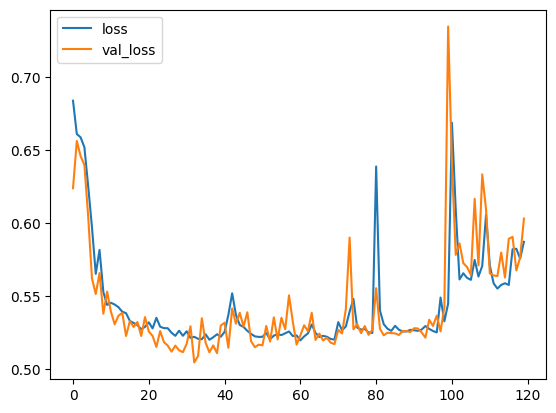

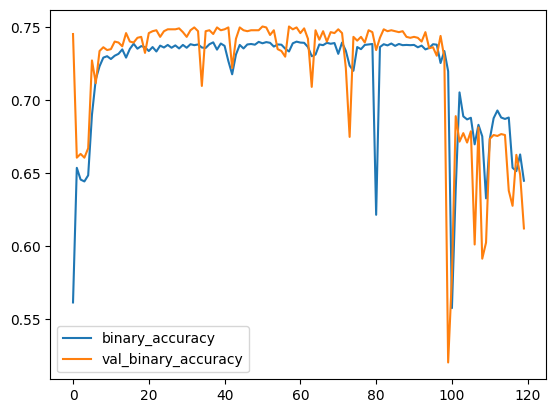

In [83]:
df_his = pd.DataFrame(his.history)
df_his[["loss",  "val_loss"]].plot()
df_his[["binary_accuracy", "val_binary_accuracy"]].plot()

model plt

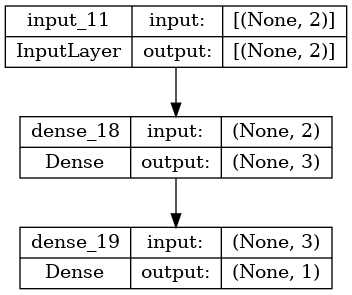

In [35]:
keras.utils.plot_model(model, "arin1_info.png", show_shapes=True)